In [1]:
import pandas as pd
import plotly.express as px
from prophet import Prophet

/Users/lukastheurer/opt/miniconda3/envs/tsa/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_sales = pd.read_csv("../data/tsa02/store-sales/train.csv", index_col="id")
df_sales.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


### Subset
Im Folgenden schauen wir uns für den Store 50 die Produktgruppe "EGGS" an. 

- Store Nummer 50 liegt in der Stadt Ambato in der Region Tungurahua
Der Store zählt zu den A Stores weswegen prinzipiell mal von einer besseren Datenbasis auszugehen ist. 
Das bedeutet konkret
- Mehr vorhandene Daten
- Keine Zeitreihenlücken, da Store gut besucht ist
- Viele Vergleichsdaten

In [3]:
# Filter for store_nbr == 50
df = df_sales[df_sales["store_nbr"] == 50]
df.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
1485,2013-01-01,50,AUTOMOTIVE,0.0,0
1486,2013-01-01,50,BABY CARE,0.0,0
1487,2013-01-01,50,BEAUTY,0.0,0
1488,2013-01-01,50,BEVERAGES,0.0,0
1489,2013-01-01,50,BOOKS,0.0,0


In [4]:
df_holidays = pd.read_csv("../data/tsa02/store-sales/holidays_events.csv")
df_holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


## Holidays

Der Einfachheit halber nutzen wir nur "Local" Holidays in Ambato selbst und Nationale Events.

In [5]:
print(f"Holiday unique types: {df_holidays.type.unique()}" )
print(f"Holiday unique locales: {df_holidays.locale.unique()}" )

Holiday unique types: ['Holiday' 'Transfer' 'Additional' 'Bridge' 'Work Day' 'Event']
Holiday unique locales: ['Local' 'Regional' 'National']


### Holidays dataframe erstellen
Siehe auch: https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#modeling-holidays-and-special-events

In [6]:
ambato_holidays = pd.DataFrame({
  'holiday': 'locales',
  'ds': df_holidays[df_holidays["locale_name"] == "Ambato"].date,
  'lower_window': -1,
  'upper_window': 1,
})

national_events = pd.DataFrame({
  'holiday': 'national',
  'ds': df_holidays[(df_holidays["locale"] == "National") & (df_holidays["transferred"] == False)].date,
  'lower_window': -1,
  'upper_window': 1
  })

holidays = pd.concat([ambato_holidays, national_events])

## EDA

In [7]:
df_grouped_products = df.groupby("family").sum()
df_grouped_products.sort_values("sales", inplace=True, ascending=False)

### Verschiedene Plots

In [8]:
fig = px.bar(df_grouped_products, x=df_grouped_products.index, y="sales", title="Menge verkaufter Einheiten pro Produktkategorie")
fig.show()

In [9]:
df.sort_values("date", inplace=True)
fig = px.line(df, x="date", y="sales", title="Verkäufe der einzelnen Produktgruppen über die Zeit", color="family")
fig.update_layout(hovermode="x")
fig.show()

/var/folders/rt/5b3g3jv94gs8w3904s_zgk180000gp/T/ipykernel_3302/2752978330.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [10]:
df_eggs = df[df["family"] == "EGGS"]
df_eggs.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
1495,2013-01-01,50,EGGS,0.0,0
3277,2013-01-02,50,EGGS,215.0,0
5059,2013-01-03,50,EGGS,103.0,0
6841,2013-01-04,50,EGGS,130.0,0
8623,2013-01-05,50,EGGS,169.0,0


In [11]:
fig = px.line(df_eggs, x='date', y='sales', title='Anzahl der verkauften Eier über die Zeit')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.update_layout(hovermode="x")
fig.show()

## Was sehen wir im oberen Run-Sequence Plot?

- Die am auffälligste staffindende Saisonlität ist die Wöchentliche
- Sonntags werden am meisten Eier verkauft
- Man sieht einen Drop um Neujahr. Evtl können wir dieses Phänomen mithilfe des Modells modellieren. Vermutlich wäre aber ein forward fill bzw ein mean-fill auf Tagesbasis der bessere und einfacherere Weg.

### Aufbereitung der Trainingsdaten
Der Einfachheit halber erstellen wir einen train/test split auf Basis der letzten 30 Tage im Trainingsdataframe

In [12]:
df_eggs.rename(columns={"date" : "ds", "sales":"y"}, inplace=True)
df_eggs.head()

/var/folders/rt/5b3g3jv94gs8w3904s_zgk180000gp/T/ipykernel_3302/1978711137.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ds,store_nbr,family,y,onpromotion
id,,,,,
1495,2013-01-01,50,EGGS,0.0,0
3277,2013-01-02,50,EGGS,215.0,0
5059,2013-01-03,50,EGGS,103.0,0
6841,2013-01-04,50,EGGS,130.0,0
8623,2013-01-05,50,EGGS,169.0,0


## Decomposition

In [13]:
from darts.timeseries import TimeSeries
# Transform datafram to darts time series
ts = TimeSeries.from_dataframe(df_eggs, time_col="ds", value_cols="y",freq="D", fill_missing_dates=True, fillna_value=True)

### ACF und PACF Plot auf Original zeitreihe

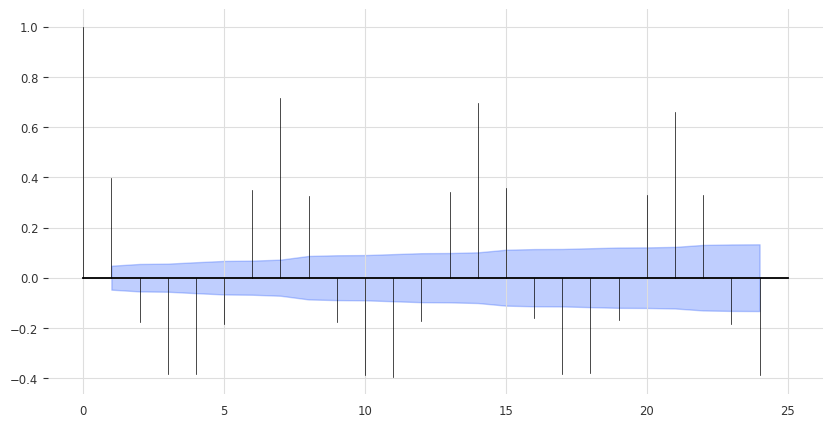

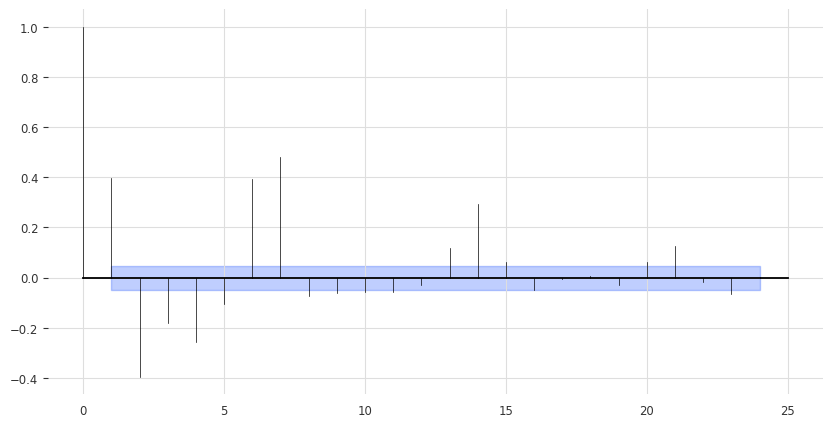

In [14]:
from darts.utils.statistics import extract_trend_and_seasonality, plot_acf, plot_pacf
plot_acf(ts)
plot_pacf(ts)

### Entfernen von Trend und Saisonalität
Mithilfe der STL Decompisition versuchen wir die Saisonale Komponente zu bestimmen und herauszurechnen. Im Nachfologenden haben wir uns für die wöchentliche Saisonalität entschieden, weil auch die Prognose nacher optimalerweise auf Wochen oder Monatsbasis erfolgen soll.

In [15]:
from darts.utils.statistics import check_seasonality, remove_seasonality, remove_trend
from darts.utils.statistics import SeasonalityMode

ts_wo_trend = remove_trend(ts, model=SeasonalityMode.ADDITIVE)
ts_wo_seas = remove_seasonality(ts_wo_trend, freq=7, model=SeasonalityMode.ADDITIVE, method="STL")

### Betrachtung Residuals

Eine Betrachtung der übrigen Residuals hilft uns bei folgenden Fragestellungen
- ist die Zeitreihe stationär
- Welche Lags wären für ein Modell wichtig für eine saubere Prognose

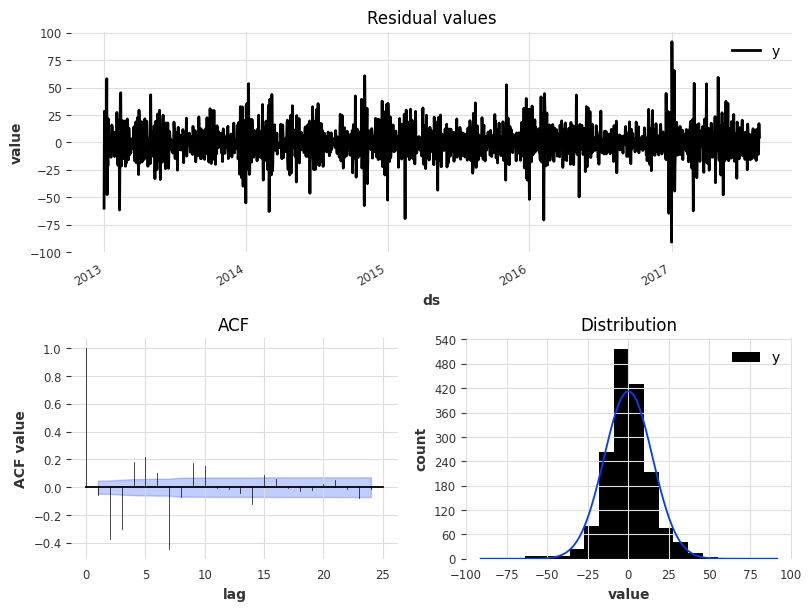

In [16]:
from darts.utils.statistics import plot_residuals_analysis
plot_residuals_analysis(ts_wo_seas)

### Insights
- Der Fehler bleibt über die Zeit hinweg konstant
- Der ACF Plot zeigt, dass der größte Einfluss t-7 hat. 
- Bis t-10 liegt ACF über Signifikanzniveau
- Histogram bestätigt erneut stationarität nach Entfernen von Trend und Seasonality

### Test auf Stationarität mithilfe von Augmented Dickey Fuller Test
Wenn P-Value <= 0.05: Dann stationär, da Augmented-Dickey Fuller die Nullhypthose H0: Zeitreihe ist nicht stationät prüft

In [17]:
from darts.utils.statistics import stationarity_test_adf
residuals = ts_wo_seas
stationarity_test_adf(residuals)

(-14.353653104027682,
 1.0118694288084038e-26,
 25,
 1662,
 {'1%': -3.4342906911169404,
  '5%': -2.8632805908715726,
  '10%': -2.5676966486957706},
 12119.894747271148)

#### Nach Entfernen von Trend und Saisonalität haben wir nach ADF eine stationäre Zeitreihe. Wir validieren das erneut anhand eines Plots

In [18]:
df_eggs_wo_seas = ts_wo_seas.pd_dataframe()
fig = px.line(df_eggs_wo_seas, y="y")
fig.show()

/Users/lukastheurer/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



### Train Test Split
Für evtl spätere Tests splitten wir den initalen dataframe in Training und Test.

In [19]:
df_train, df_test = df_eggs.iloc[:-30], df_eggs.iloc[-30:]

### Erstelle Prophet modell mit Feiertage und Events
Der Run-Sequence Plot gibt Aufschluss über die Eigenschaften der Zeitreihe:
- Da Error und Saisonalit unabhängig vom Trend sind handelt es sich bei der Zeitreihe um eine additive Zeitreihe -> Additiv
- Auf den ersten Blick weist die Zeitreihe keine sehr starke jährlich Saisonalität auf, dennoch wollen wir dem Modell das Einbeziehen einer jählichen Saisonalität nicht "verbieten" -> yearly_seasonality=auto
- Die wöchentliche Saisonalität ist offensichtlich -> weekly_seasonality=True
- daily_seasonality -> Unwichtig, da keine stündlichen  Daten
- seasonality_prior_scale: Zwischen wöchentl. Tiefpunkt und Hochpunkt liegt ca Faktor 2.5. evtl müssen wir diesen Parameter anpassen umd einen besseren Fit an die Saisolität zu gewähleisten

### Model fit + Cross Validation

In [20]:
from prophet.diagnostics import cross_validation
model = Prophet(holidays=holidays,growth="flat", weekly_seasonality=True, seasonality_mode="additive")
model.fit(df_train)
df_cv = cross_validation(model, initial='730 days', horizon = '30 days')


11:54:58 - cmdstanpy - INFO - Chain [1] start processing
11:54:58 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/60 [00:00<?, ?it/s]11:54:58 - cmdstanpy - INFO - Chain [1] start processing
11:54:58 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/60 [00:00<00:10,  5.68it/s]11:54:58 - cmdstanpy - INFO - Chain [1] start processing
11:54:58 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 2/60 [00:00<00:09,  5.85it/s]11:54:58 - cmdstanpy - INFO - Chain [1] start processing
11:54:58 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 3/60 [00:00<00:09,  5.86it/s]11:54:58 - cmdstanpy - INFO - Chain [1] start processing
11:54:58 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 4/60 [00:00<00:09,  5.86it/s]11:54:59 - cmdstanpy - INFO - Chain [1] start processing
11:54:59 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 5/60 [00:00<00:09,  5.86it/s]11:54:59 - cmdstanpy - INFO - Chain [1] start processi

In [21]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head(30)

,horizon,mse,rmse,mae,mdape,smape,coverage
0,3 days,543.433077,23.311651,18.531934,0.148239,0.169008,0.782123
1,4 days,534.141809,23.111508,18.155221,0.134581,0.167179,0.794227
2,5 days,513.457273,22.659596,17.815384,0.133668,0.162997,0.794693
3,6 days,443.541274,21.060420,17.042330,0.132336,0.160979,0.805587
4,7 days,377.968992,19.441425,15.838258,0.124437,0.149334,0.843575
5,8 days,424.247400,20.597267,15.320913,0.116416,0.151343,0.860335
6,9 days,463.444895,21.527770,15.846418,0.116416,0.150461,0.860335
7,10 days,519.270407,22.787506,17.049434,0.134152,0.162002,0.827467
8,11 days,458.637737,21.415829,16.902037,0.140316,0.154474,0.816853
9,12 days,484.131131,22.002980,16.848093,0.135983,0.154808,0.822253


/var/folders/rt/5b3g3jv94gs8w3904s_zgk180000gp/T/ipykernel_3302/3472151116.py:4: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



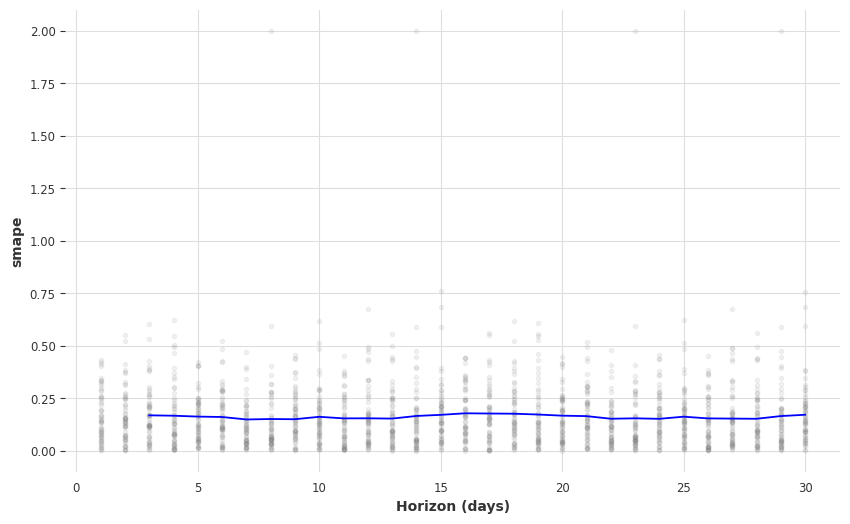

In [22]:
# Python
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric="smape")
fig.show()

/var/folders/rt/5b3g3jv94gs8w3904s_zgk180000gp/T/ipykernel_3302/3485568620.py:2: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



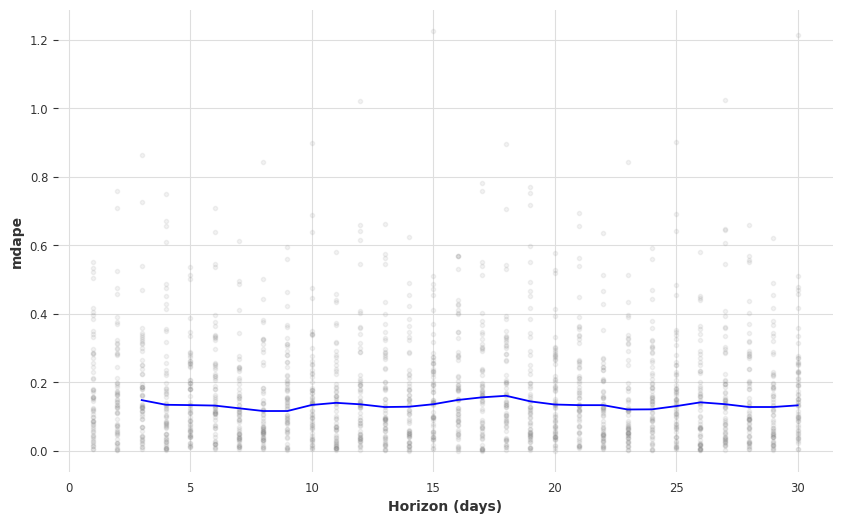

In [23]:
fig = plot_cross_validation_metric(df_cv, metric="mdape")
fig.show()

### Predict the future

In [24]:
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1679,2017-08-11,94.290480,65.615647,122.125446
1680,2017-08-12,140.472543,113.601753,166.811602
1681,2017-08-13,170.078485,141.821278,197.006020
1682,2017-08-14,111.928329,84.171409,138.566687
1683,2017-08-15,87.208011,61.008156,116.536433


/Users/lukastheurer/opt/miniconda3/envs/tsa/lib/python3.10/site-packages/prophet/plot.py:226: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/lukastheurer/opt/miniconda3/envs/tsa/lib/python3.10/site-packages/prophet/plot.py:349: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/lukastheurer/opt/miniconda3/envs/tsa/lib/python3.10/site-packages/prophet/plot.py:352: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on t

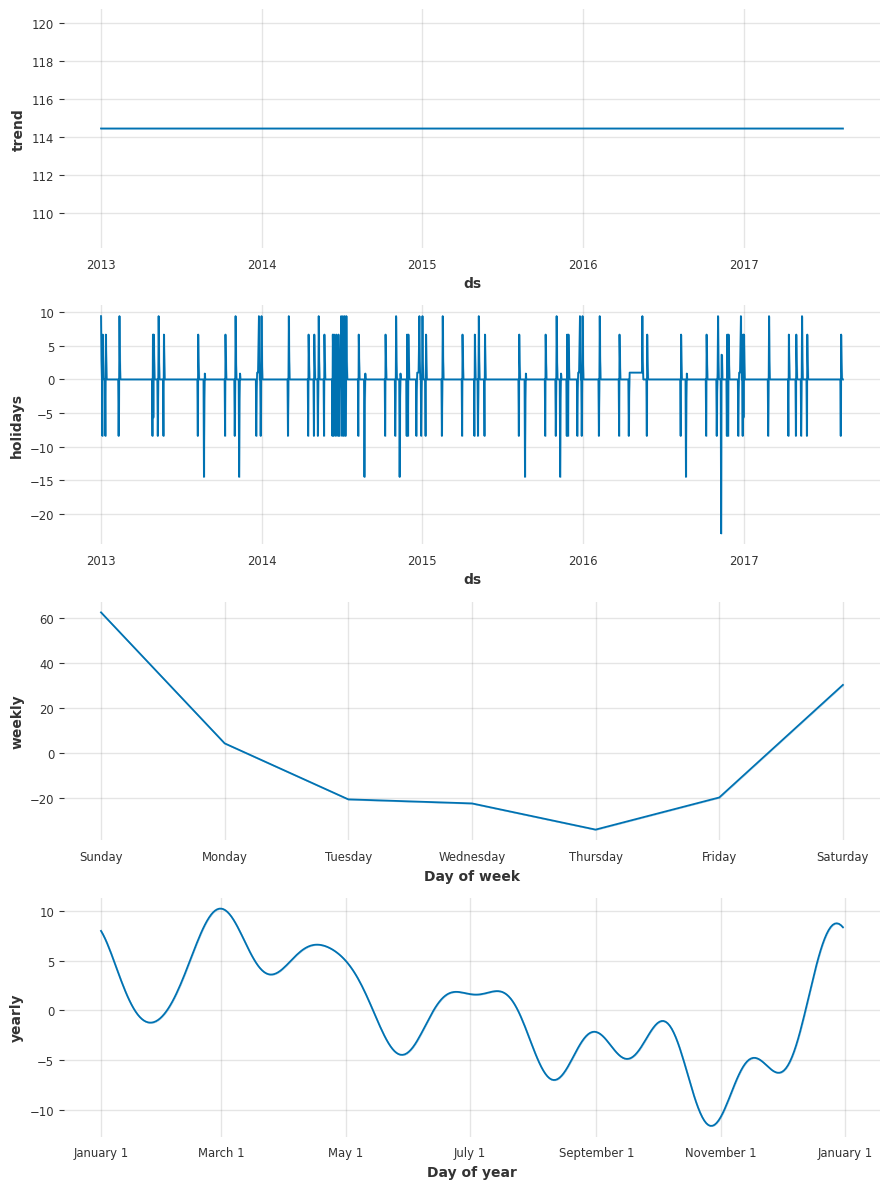

In [25]:
model.plot_components(forecast);

In [26]:
# Python
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

cutoffs = pd.to_datetime(['2017-01-01'])

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(holidays=holidays,growth="flat", weekly_seasonality=True, seasonality_mode="additive", **params).fit(df_eggs)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['mdape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print("################# Results: #################")
print(tuning_results)

best_params = all_params[np.argmin(rmses)]
print("################# Best params: #################")
print(best_params)

11:55:11 - cmdstanpy - INFO - Chain [1] start processing
11:55:11 - cmdstanpy - INFO - Chain [1] done processing
11:55:12 - cmdstanpy - INFO - Chain [1] start processing
11:55:12 - cmdstanpy - INFO - Chain [1] done processing
11:55:13 - cmdstanpy - INFO - Chain [1] start processing
11:55:13 - cmdstanpy - INFO - Chain [1] done processing
11:55:14 - cmdstanpy - INFO - Chain [1] start processing
11:55:14 - cmdstanpy - INFO - Chain [1] done processing
11:55:14 - cmdstanpy - INFO - Chain [1] start processing
11:55:14 - cmdstanpy - INFO - Chain [1] done processing
11:55:15 - cmdstanpy - INFO - Chain [1] start processing
11:55:15 - cmdstanpy - INFO - Chain [1] done processing
11:55:15 - cmdstanpy - INFO - Chain [1] start processing
11:55:15 - cmdstanpy - INFO - Chain [1] done processing
11:55:16 - cmdstanpy - INFO - Chain [1] start processing
11:55:16 - cmdstanpy - INFO - Chain [1] done processing
11:55:16 - cmdstanpy - INFO - Chain [1] start processing
11:55:16 - cmdstanpy - INFO - Chain [1]

################# Results: #################
    changepoint_prior_scale  seasonality_prior_scale      rmse
0                     0.001                     0.01  0.177394
1                     0.001                     0.10  0.158981
2                     0.001                     1.00  0.158755
3                     0.001                    10.00  0.158747
4                     0.010                     0.01  0.177394
5                     0.010                     0.10  0.158981
6                     0.010                     1.00  0.158755
7                     0.010                    10.00  0.158747
8                     0.100                     0.01  0.177394
9                     0.100                     0.10  0.158981
10                    0.100                     1.00  0.158755
11                    0.100                    10.00  0.158747
12                    0.500                     0.01  0.177394
13                    0.500                     0.10  0.158981
14        

11:55:30 - cmdstanpy - INFO - Chain [1] start processing
11:55:30 - cmdstanpy - INFO - Chain [1] done processing


#### Fazit
- Die Analyse der Zeitreihe hat uns erste Hinweise auf eine Parametrisierung des Prophet Modells gegeben
- Unter https://facebook.github.io/prophet/docs/diagnostics.html werden Parameter gelistet, die weiter getuned werden können.
- Beim einfachen Tuning haben sich folgende Parameter als Beste herausgestellt: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0}
- Bei der Zeitreihenanalyse ist es besonders wichtig, dass Overfitting vermieden wird. Dazu eignet sich die Expanding Windows Validierung am besten.